In [18]:
from methods_preprocessing import *

In [19]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

### 1. Fetch datasets with classifications and corrected classifications to see which ones were missed

In [20]:
nos_nu_clf_preprocessed = pd.read_excel('datasets/nos_nu_clf_preprocessed.xlsx')
nos_nu_clf_preprocessed_corrected = pd.read_excel('datasets/nos_nu_clf_preprocessed_clf_corrected.xlsx')

In [21]:
# Check
print(nos_nu_clf_preprocessed['id'].equals(nos_nu_clf_preprocessed_corrected['id']))

True


#### a. Combine

In [22]:
# Take the classifications from before the manual correction and add it to the corrected dataframe for comparison
nos_nu_clf_preprocessed_corrected['politician_in_img_uncorrected'] = nos_nu_clf_preprocessed['politician_in_img']

#### b. Pre-process

In [52]:
df = nos_nu_clf_preprocessed_corrected.copy()

In [53]:
from methods_preprocessing import fix_and_eval_list

df['politician_in_img_uncorrected'] = (
    df['politician_in_img_uncorrected'].apply(fix_and_eval_list)
)
df['politician_in_img'] = (
    df['politician_in_img'].apply(fix_and_eval_list)
)

In [54]:
final_df = df.copy()

##### i. Inspect if list formatting is correct

In [55]:
subset = df.loc[df['politician_in_img'].apply(lambda x: len(x) > 0)]

In [56]:
subset[['politician_in_img', 'politician_in_img_uncorrected']]

,politician_in_img,politician_in_img_uncorrected
4,[Caroline van der Plas],[Caroline van der Plas]
12,[Dilan Yesilgöz],[Dilan Yesilgöz]
21,[Lilian Marijnissen],[Lilian Marijnissen]
29,[Caroline van der Plas],[Caroline van der Plas]
32,[Caroline van der Plas],[Caroline van der Plas]
44,[Henri Bontebal],[Henri Bontebal]
57,"[Caroline van der Plas, Pieter Omtzigt]",[Pieter Omtzigt]
58,[Rob Jetten],[Rob Jetten]
73,[Rob Jetten],[Rob Jetten]
75,[Joost Eerdmans],[Joost Eerdmans]


##### ii. Select relevant columns

In [57]:
clf_compare_df = df[['id', 'dataset', 'id', 'url', 'img_link', 'alt_txt', 'title', 'politician_in_img', 'politician_in_img_uncorrected']].copy()

In [58]:
clf_compare_df['missed_clf_names'] = clf_compare_df.apply(lambda row: compare_lists_as_sets(row, 'politician_in_img', 'politician_in_img_uncorrected'), axis=1)

##### iii. Check if correct (delete test.xlsx after checking)

### c. Get an insight into the correction results

In [59]:
total_count_uncorrected = [name for sublist in clf_compare_df['politician_in_img_uncorrected'] for name in sublist]
total_count_corrected = [name for sublist in clf_compare_df['politician_in_img'] for name in sublist]
print(f'Before correction, {len(total_count_uncorrected)} labels were assigned.')
print(f'After correction, {len(total_count_corrected)} labels were assigned.')

Before correction, 349 labels were assigned.
After correction, 411 labels were assigned.


In [60]:
non_empty_counts = clf_compare_df[clf_compare_df['missed_clf_names'].apply(lambda x: len(x) > 0)]
non_empty_articles = clf_compare_df[clf_compare_df['politician_in_img'].apply(lambda x: len(x) > 0)]

uncorrected_classifications = clf_compare_df[clf_compare_df['politician_in_img_uncorrected'].apply(lambda x: len(x) > 0)]
final_classifications = clf_compare_df[clf_compare_df['politician_in_img'].apply(lambda x: len(x) > 0)]

In [61]:
clf_total_listed = [name for sublist in clf_compare_df['politician_in_img'] for name in sublist]
clf_missed_listed = [name for sublist in clf_compare_df['missed_clf_names'] for name in sublist]

clf_total_count = pd.Series(clf_total_listed).value_counts().rename_axis('politician').reset_index(name='clf_total')
clf_missed_count = pd.Series(clf_missed_listed).value_counts().rename_axis('politician').reset_index(name='clf_missed')

clf_count = clf_total_count.merge(clf_missed_count, on=['politician'], how='left')
clf_count['clf_missed'] = clf_count['clf_missed'].fillna(0).astype(int)

In [62]:
print(f'Finally, {len(clf_total_listed)} politicians were labelled.\n')
print(f'Out of the {clf_compare_df.shape[0]} articles in the data with an image, {non_empty_articles.shape[0]} articles contain one or more party leaders in the main image.')
print(f'However, in the original dataset, {uncorrected_classifications.shape[0]} articles are labelled with at least one party leader in the main image.\nThis means that {(non_empty_articles.shape[0]-uncorrected_classifications.shape[0])} article ids containing a main image of potential interest were recovered by manual correction.\n')
print(f'In total, {non_empty_counts['missed_clf_names'].value_counts().sum()} main image labels were incomplete, with a total of {len(clf_missed_listed)} missed politicians by not being represented in the classification set - or, in other words: \nthey were missed by both the face detection algorithms applied in the data collection process.')

Finally, 411 politicians were labelled.

Out of the 10057 articles in the data with an image, 296 articles contain one or more party leaders in the main image.
However, in the original dataset, 273 articles are labelled with at least one party leader in the main image.
This means that 23 article ids containing a main image of potential interest were recovered by manual correction.

In total, 51 main image labels were incomplete, with a total of 62 missed politicians by not being represented in the classification set - or, in other words: 
they were missed by both the face detection algorithms applied in the data collection process.


In [63]:
clf_count['in_clf_set'] = clf_count['clf_total']-clf_count['clf_missed']

#### i. Restored with first check, i.e. by inspecting articles where already one politician was labelled to see if the labels list was inclusive and exhaustive

In [64]:
subset = clf_compare_df.loc[
    (clf_compare_df['politician_in_img_uncorrected'].apply(len) == 0) & 
    (clf_compare_df['politician_in_img'].apply(len) > 0)
]

In [65]:
subset_count = len([name for sublist in subset['missed_clf_names'] for name in sublist])

In [66]:
print(f'Number of politicians restored with first check: {subset_count}')

Number of politicians restored with first check: 25


#### ii. Restored with second check, i.e. by inspecting the articles with a politician's/party reference in title or alt-text

In [67]:
print(f'Number of politicians restored with second check: {len(clf_missed_listed)-subset_count}')

Number of politicians restored with second check: 37


### 2. Analyze which faces got missed the most

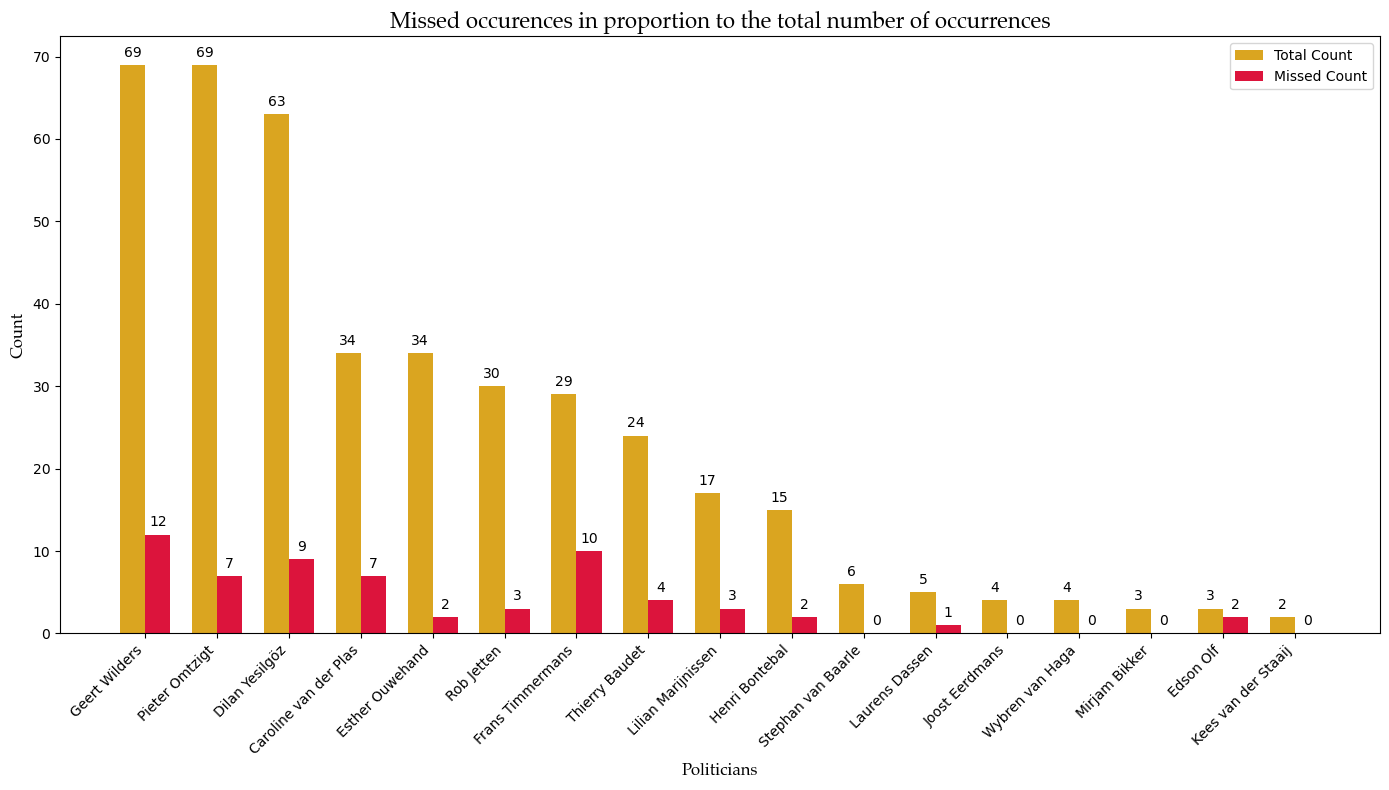

In [68]:
n_politicians = len(clf_count['politician'])
bar_width = 0.35

r1 = np.arange(n_politicians)
r2 = [x + bar_width for x in r1]

fig, ax = plt.subplots(figsize=(14, 8))
ax.bar(r1, clf_count['clf_total'], color='goldenrod', width=bar_width, label='Total Count')
ax.bar(r2, clf_count['clf_missed'], color='crimson', width=bar_width, label='Missed Count')

for i in range(n_politicians):
    ax.text(r1[i], clf_count['clf_total'][i] + 1, str(clf_count['clf_total'][i]), ha='center')
    ax.text(r2[i], clf_count['clf_missed'][i] + 1, str(clf_count['clf_missed'][i]), ha='center')

ax.set_xlabel('Politicians', fontdict=axis_font)
ax.set_ylabel('Count', fontdict=axis_font)
ax.set_title('Missed occurences in proportion to the total number of occurrences', fontdict=title_font)
ax.set_xticks([r + bar_width / 2 for r in range(n_politicians)])
ax.set_xticklabels(clf_count['politician'], rotation=45, ha='right')

ax.legend()

plt.tight_layout()
#plt.savefig('../z__visual-outputs-matplotlib/barchart_total_to_missed.pdf', format='pdf', bbox_inches='tight')
plt.show()

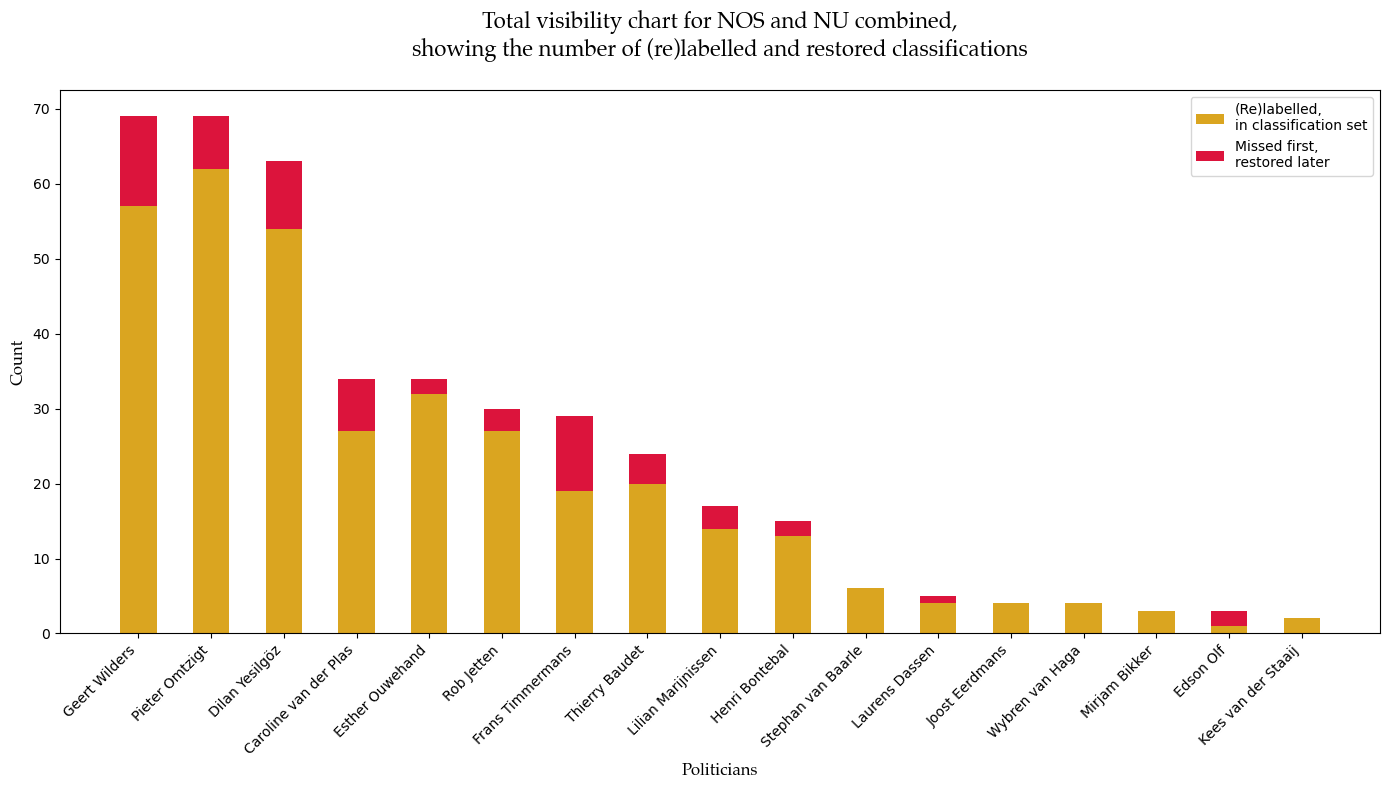

In [69]:
n_politicians = len(clf_count['politician'])
bar_width = 0.5  # Bar width

r = np.arange(n_politicians)

fig, ax = plt.subplots(figsize=(14, 8))

ax.bar(r, clf_count['in_clf_set'], color='goldenrod', width=bar_width, label='(Re)labelled,\nin classification set')
ax.bar(r, clf_count['clf_missed'], color='crimson', width=bar_width, bottom=clf_count['in_clf_set'], label='Missed first,\nrestored later')

ax.set_xlabel('Politicians', fontdict=axis_font)
ax.set_ylabel('Count', fontdict=axis_font)
ax.set_title('Total visibility chart for NOS and NU combined,\nshowing the number of (re)labelled and restored classifications\n', fontdict=title_font)
ax.set_xticks(r)
ax.set_xticklabels(clf_count['politician'], rotation=45, ha='right')
ax.legend()

plt.tight_layout()
plt.show()

The missed_counts give insight into which faces were not detected when scraping the news images. This has as a consequence that the images did not end up in the classification set, and were therefore not embedded, and finally, not classified. </br>
The very last accuracy check (notebook: 01_preprocessing_nos_nu.ipynb) contained two steps. First, the images that already had one or more politician's label assigned to it, were checked for inclusivity and exhaustiveness. These news images are found in /data/images/clf_images_to_check. </br>
Second, the images for which a politician's or political party's name appeared in either the title or the alt_text, but did not have a politician's label assigned to the image yet, were checked whether they indeed did not have a politician of interest apparent in the image. These news images are found in /data/images/no_clf_images_to_check. </br>
</br>
After the missing classifications were manually added to the column with classifications, it was found that one or more classifications were missing for 51 articles, and this happens more often for some politicians than for others. However, the images of which not all faces were detected show that, from a visual data processing perspective, this can sometimes be explained by the face that a face was in low resolution, poor in light, or taken from an odd angle. For some images, the faces were actually clear, and one is left to guess why the combination of two face detection algorithms did not succeed in cutting out that face. This might be caused by data time-out in downloading images, or a biased algorithm. 

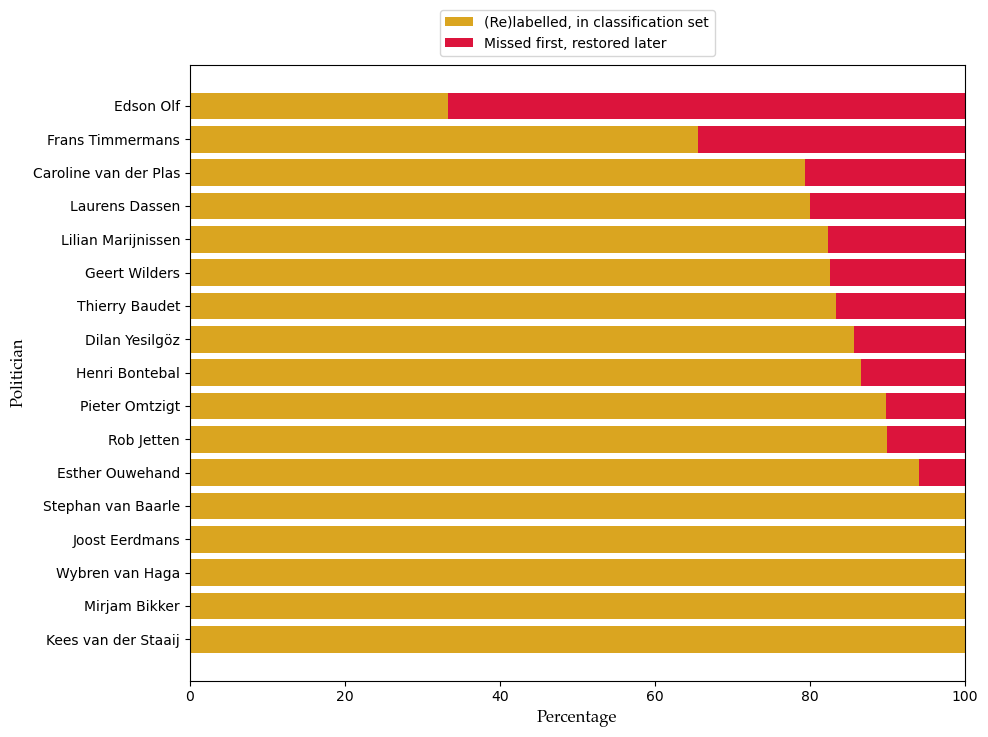

In [70]:
df = clf_count.copy()
df['proportion_missed'] = (df['clf_missed'] / df['clf_total']) * 100
df['proportion_correct'] = 100 - df['proportion_missed']

df.sort_values(by='proportion_missed', ascending=True, inplace=True)

plt.figure(figsize=(10, 8))
plt.barh(df['politician'], df['proportion_correct'], color='goldenrod', label='(Re)labelled, in classification set')
plt.barh(df['politician'], df['proportion_missed'], left=df['proportion_correct'], color='crimson', label='Missed first, restored later')

plt.xlabel('Percentage', font=axis_font)
plt.ylabel('Politician', font=axis_font)
#plt.title('Normalized Chart Showing the Proportion of Politicians Missed in Classification Set\n', fontdict=title_font)
plt.legend(bbox_to_anchor=(0.5, 1.1), loc='upper center')

plt.savefig('../z__visual-outputs-matplotlib/normalized_barchart_missed_pol.pdf', format='pdf', bbox_inches='tight')
plt.show()

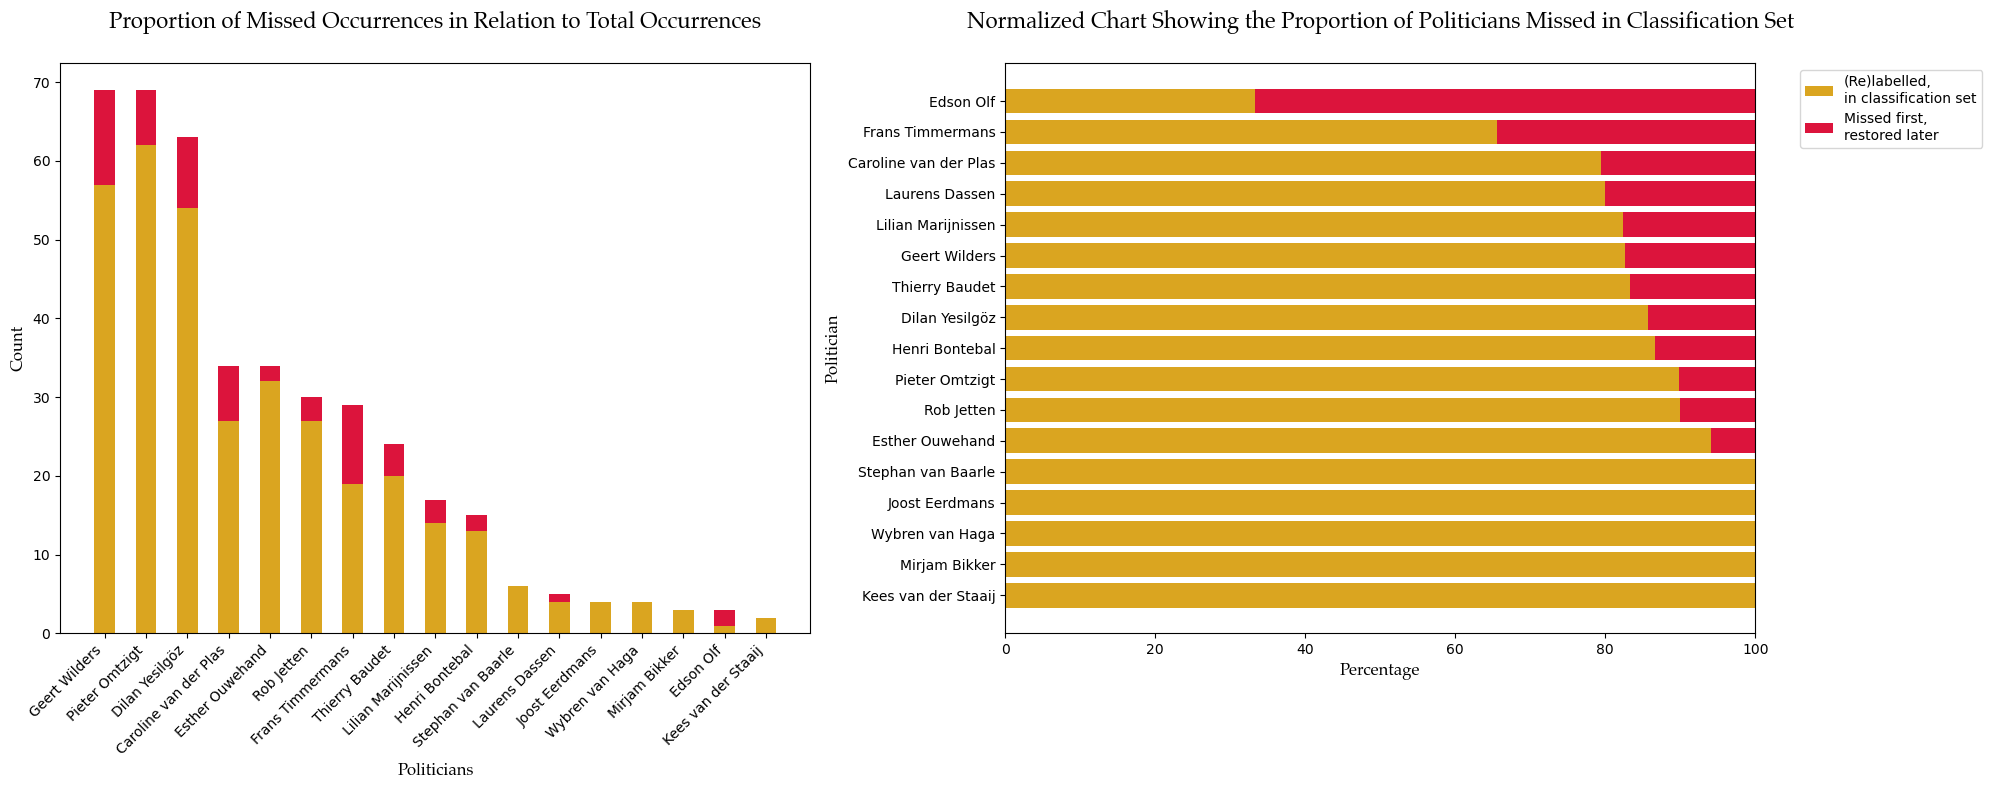

In [71]:
fig, axs = plt.subplots(1, 2, figsize=(20, 8))

# First
n_politicians = len(clf_count['politician'])
bar_width = 0.5
r = np.arange(n_politicians)

axs[0].bar(r, clf_count['in_clf_set'], color='goldenrod', width=bar_width, label='In Set')
axs[0].bar(r, clf_count['clf_missed'], color='crimson', width=bar_width, bottom=clf_count['in_clf_set'], label='Missed')

axs[0].set_xlabel('Politicians', fontdict=axis_font)
axs[0].set_ylabel('Count', fontdict=axis_font)
axs[0].set_title('Proportion of Missed Occurrences in Relation to Total Occurrences\n', fontdict=title_font)
axs[0].set_xticks(r)
axs[0].set_xticklabels(clf_count['politician'], rotation=45, ha='right')

# Second
df = clf_count.copy()
df['proportion_missed'] = (df['clf_missed'] / df['clf_total']) * 100
df['proportion_correct'] = 100 - df['proportion_missed']

df.sort_values(by='proportion_missed', ascending=True, inplace=True)

axs[1].barh(df['politician'], df['proportion_correct'], color='goldenrod', label='(Re)labelled,\nin classification set')
axs[1].barh(df['politician'], df['proportion_missed'], left=df['proportion_correct'], color='crimson', label='Missed first,\nrestored later')

axs[1].set_xlabel('Percentage', fontdict=axis_font)
axs[1].set_ylabel('Politician', fontdict=axis_font)
axs[1].set_title('Normalized Chart Showing the Proportion of Politicians Missed in Classification Set\n', fontdict=title_font)
axs[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

### 3. Export dataframes for multimodal analysis (found in /output folder)
1. Full dataset
2. Subsets: </br>
   a. Articles with images that contain politicians </br>
   b. Articles with politicians in main image, but no title reference
   c. Articles without images that contain politicians, but with titles or visual sibscripts that reference politicians or their party </br>
4. Value-counts for visualization purposes

In [74]:
df = final_df.drop(columns=['politician_in_img_uncorrected'])
from methods_preprocessing import is_non_empty_list, is_list_and_non_empty, check_clf_ref
from wordlists_preprocessing import politician_party

In [77]:
# 1. Full dataset
df.to_parquet('datasets/output/full_df_clf_corrected.parquet')
df.to_excel('datasets/output/full_df_clf_corrected.xlsx')

df.to_parquet('../f__nos-nu-analysis/datasets/input/full_df_clf_corrected.parquet')

In [78]:
# Check the type of each value in the 'politician_in_img' column
print(df['politician_in_img'].apply(type).unique())

[<class 'list'>]


In [79]:
# 2. Subsets
#    a.  Only articles in which politicians occur in the main image
political_images = df['politician_in_img'].map(is_non_empty_list)

pol_img_df = df[political_images]
pol_img_df.to_parquet('datasets/output/pol_img_only.parquet')
pol_img_df.to_parquet('../f__nos-nu-analysis/datasets/input/pol_img_only.parquet')

In [80]:
political_images.unique()

array([False,  True])

In [81]:
#    b.  Articles with politicians in main image, but no reference in title
pol_ref_results_df = check_clf_ref(pol_img_df, politician_party)
pol_ref_results_df.to_parquet('datasets/output/pol_img_only_ref_results.parquet')
pol_ref_results_df.to_parquet('../f__nos-nu-analysis/datasets/input/pol_img_only_ref_results.parquet')

In [82]:
#    c.  Articles without politicians in main image, but referenced in title/alt_txt
non_political_images = df[~political_images]
columns_with_title_or_alt_txt = [
    col for col in df.columns
    if ('_title' in col or '_alt_txt' in col) and
       not ('Positions' in col or 'Politics' in col or 'Issues' in col or 'Countries' in col)
]

no_pol_img_but_ref_condition = non_political_images[columns_with_title_or_alt_txt].map(is_list_and_non_empty)
rows_no_pol_img_but_ref_condition = no_pol_img_but_ref_condition.any(axis=1)
non_pol_img_but_ref = non_political_images[rows_no_pol_img_but_ref_condition]

non_pol_img_but_ref.to_parquet('datasets/output/non_pol_img_but_ref.parquet')
non_pol_img_but_ref.to_parquet('../f__nos-nu-analysis/datasets/input/non_pol_img_but_ref.parquet')